In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

In [9]:
age_groups = ['Under 1 year', '1 - 4 years', '5 - 9 years', '10 - 14 years', '15 - 19 years', 
              '20 - 24 years', '25 - 29 years', '30 - 34 years', '35 - 39 years', '40 - 44 years', 
              '45 - 49 years', '50 - 54 years', '55 - 59 years', '60 - 64 years', '65 - 69 years', 
              '70 - 74 years', '75 - 79 years', '80 - 84 years', '85 years and over']

In [10]:
population_df = pd.read_csv('../data/PopByAgeGroupSupplemented.csv', index_col='Year')
birth_death_df = pd.read_csv('../data/BirthsDeathsByQuarter.csv')
migration_df = pd.read_csv('../data/NetMigrationByYear.csv', index_col='Year')

# Change unit of births and deaths to be in thousands of people
birth_death_df['Births Registered (Number)'] = birth_death_df['Births Registered (Number)'] / 1000.0
birth_death_df['Deaths Registered (Number)'] = birth_death_df['Deaths Registered (Number)'] / 1000.0

# Sum quarterly births and deaths to yearly totals
birth_death_df['Year'] = birth_death_df['Quarter'].str[:4].astype(int)
birth_death_annual = birth_death_df.groupby('Year')[['Births Registered (Number)', 'Deaths Registered (Number)']].sum()

combined_df = pd.merge(migration_df, birth_death_annual, left_index=True, right_index=True, how='outer')
combined_df = pd.merge(combined_df, population_df, left_index=True, right_index=True, how='outer')
combined_df.drop(columns=['Country', 'Origin or Destination', 'STATISTIC', 'UNIT'], axis=1, inplace=True)

combined_df = combined_df[combined_df.index >= 1987]
combined_df.tail()

,Estimated Migration (Persons in April) (Thousand),Births Registered (Number),Deaths Registered (Number),Under 1 year,1 - 4 years,5 - 9 years,10 - 14 years,15 - 19 years,20 - 24 years,25 - 29 years,...,40 - 44 years,45 - 49 years,50 - 54 years,55 - 59 years,60 - 64 years,65 - 69 years,70 - 74 years,75 - 79 years,80 - 84 years,85 years and over
Year,,,,,,,,,,,,,,,,,,,,,
2020,44.7,55.959,31.765,58.2,250.5,350.2,354.7,327.4,310.5,296.4,...,394.3,362.6,319.9,296.0,261.6,228.7,192.5,138.5,90.8,75.6
2021,21.8,58.443,33.055,55.9,245.0,342.7,364.0,329.0,311.4,294.8,...,403.6,368.2,329.5,301.2,268.5,234.1,196.2,147.2,92.4,77.5
2022,51.7,57.540,35.477,57.7,238.2,343.6,374.9,337.8,311.9,299.1,...,414.7,376.0,342.9,309.7,275.8,240.5,204.7,155.0,96.8,84.4
2023,77.7,54.678,35.459,55.7,238.1,338.6,379.2,349.5,317.8,308.5,...,427.7,382.7,354.5,316.3,285.2,244.8,210.5,162.1,101.8,87.1
2024,79.3,40.645,26.934,55.5,237.7,335.3,381.8,359.0,322.2,320.2,...,435.0,393.6,365.1,322.4,295.2,251.3,214.7,169.2,106.9,91.2


In [11]:
def create_lagged_df(df, ag, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'{ag} Lag{lag}'] = df[ag].shift(lag)
        df[f'Migration Lag{lag}'] = df['Estimated Migration (Persons in April) (Thousand)'].shift(lag)
        df[f'Births Lag{lag}'] = df['Births Registered (Number)'].shift(lag)
        df[f'Deaths Lag{lag}'] = df['Deaths Registered (Number)'].shift(lag)
    return df.dropna()

In [12]:
def evaluate_lags(df, target_col, max_lags):
    results = {}
    best_models = {}
    
    for max_lag in max_lags:
        selected_features = []
        selected_features.extend([f'{target_col} Lag{max_lag}'])
        selected_features.extend([f'Migration Lag{max_lag}', f'Births Lag{max_lag}', f'Deaths Lag{max_lag}'])
        
        df_lagged = create_lagged_df(df.copy(), target_col, max_lag)
        
        X = df_lagged[selected_features]
        y = df_lagged[target_col]
        
        X_train = X[X.index < 2019]
        X_test = X[X.index >= 2019]
        y_train = y[X.index < 2019]
        y_test = y[X.index >= 2019]
        
        model = RandomForestRegressor(random_state=5)
        
        # Param search
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [4, 6, 8, 10, 12],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 2]
        }
        
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
        # Predictions
        y_pred = best_model.predict(X_test)
        
        # Metrics
        rmse = root_mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        results[max_lag] = {'rmse': rmse, 'mape': mape, 'best_params': best_params}
        preds[max_lag] = y_pred
        y_tests[max_lag] = y_test
        best_models[max_lag] = best_model
    
    return results, best_models

In [13]:
def plot_results(results):
    lag_values = list(results.keys())
    rmse_values = [results[lag]['rmse'] for lag in lag_values]
    mape_values = [results[lag]['mape'] for lag in lag_values]
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].plot(lag_values, rmse_values, marker='o', color='b')
    axes[0].set_title('RMSE against lags')
    axes[0].set_xlabel('Lag Window (Years)')
    axes[0].set_ylabel('Root Mean Squared Error')
    axes[0].grid(True)
    
    axes[1].plot(lag_values, mape_values, marker='o', color='b')
    axes[1].set_title('R2 against lags')
    axes[1].set_xlabel('Lag Window (Years)')
    axes[1].set_ylabel('R2 Score')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Evaluating for age group: Under 1 year
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


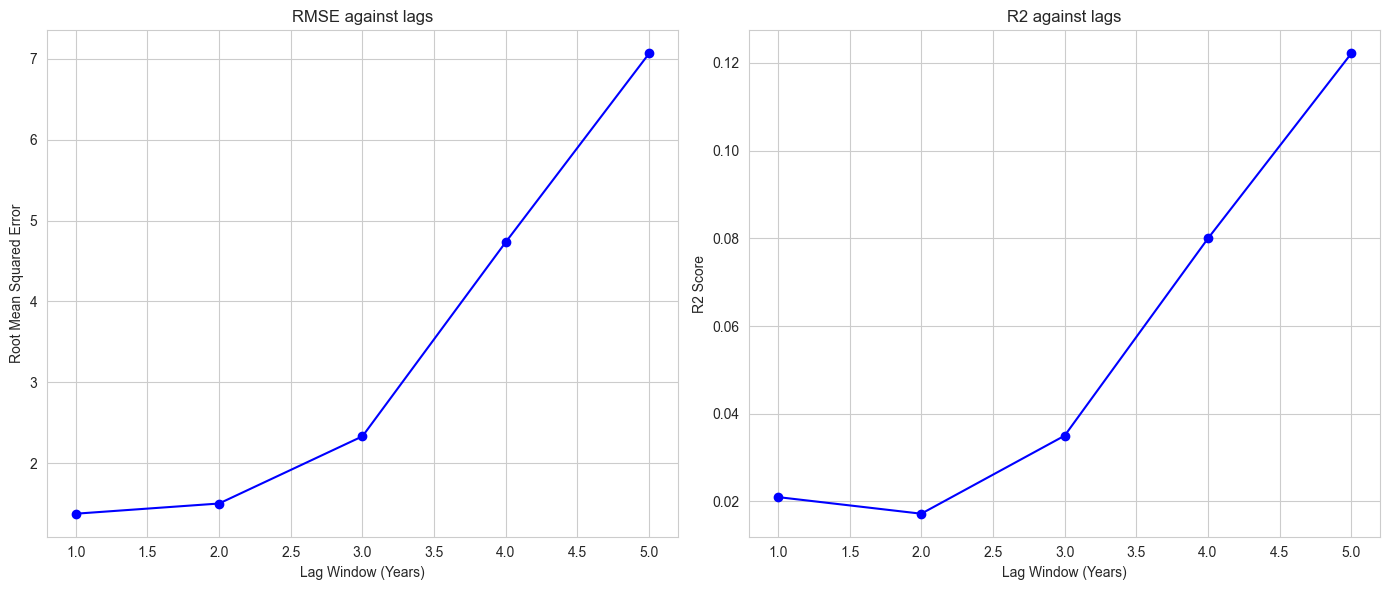

Evaluating for age group: 1 - 4 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


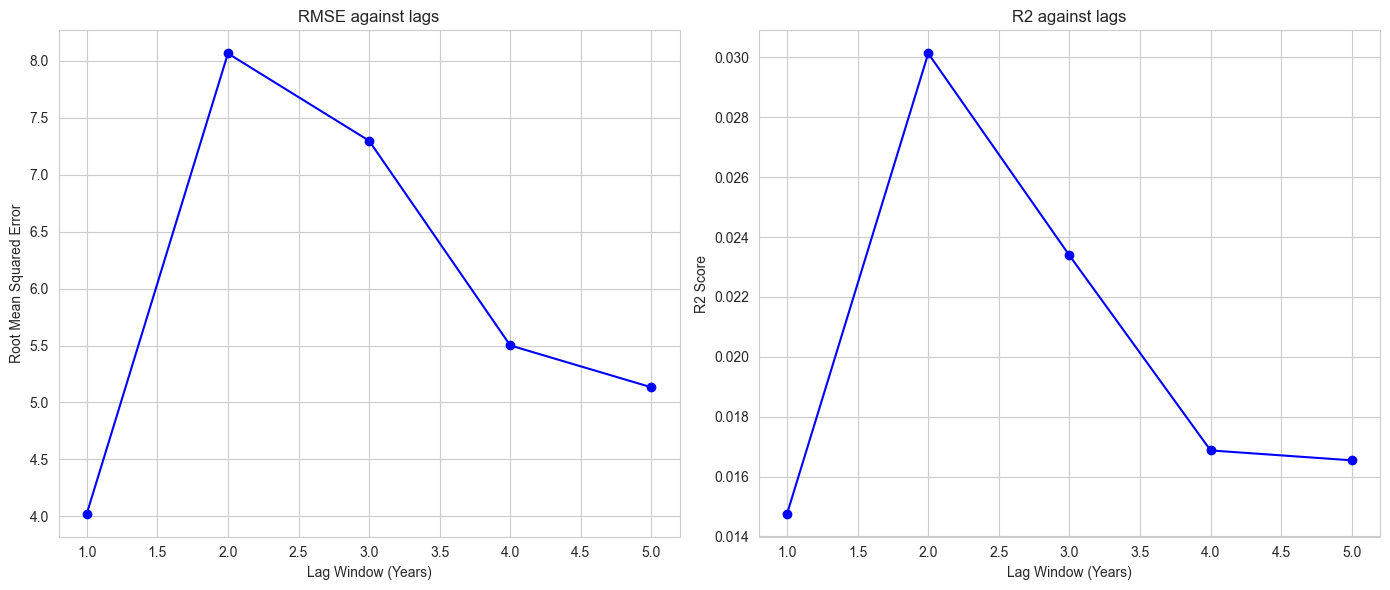

Evaluating for age group: 5 - 9 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


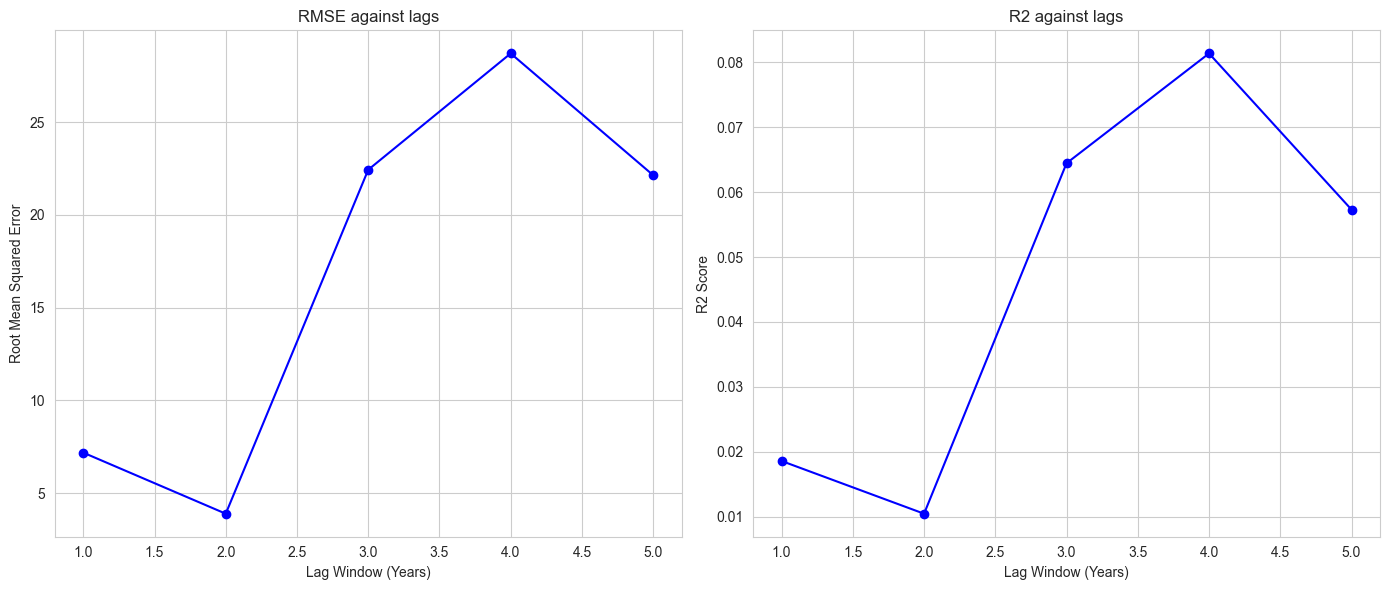

Evaluating for age group: 10 - 14 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


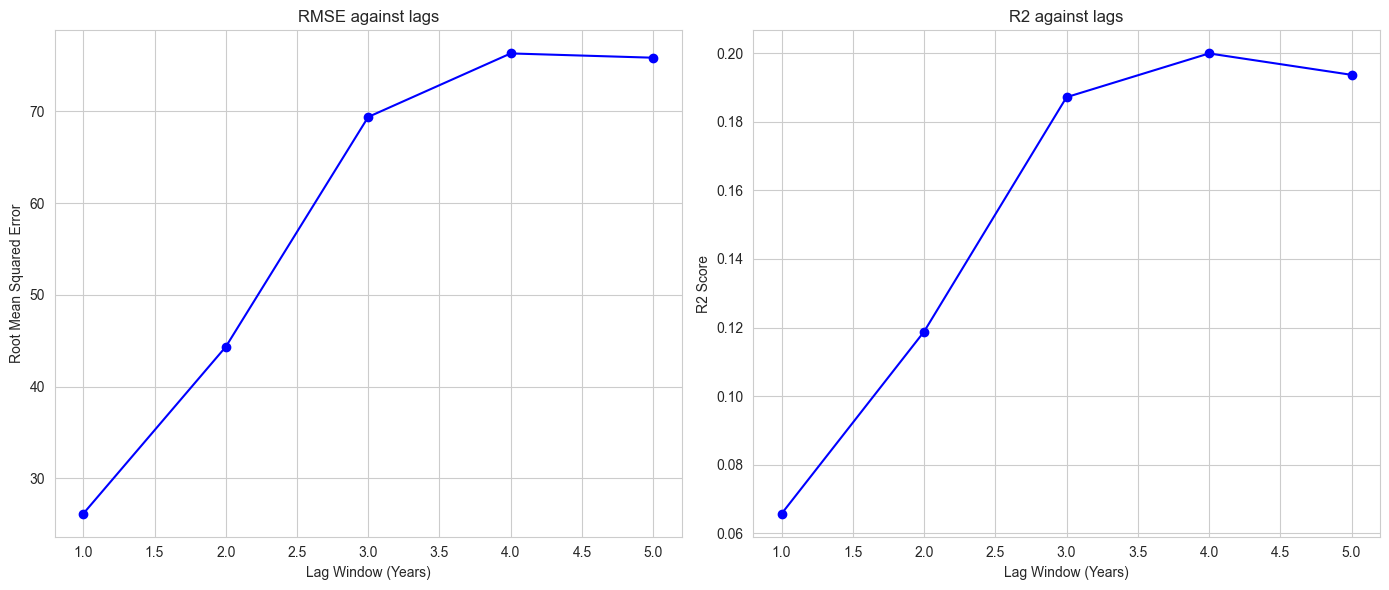

Evaluating for age group: 15 - 19 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


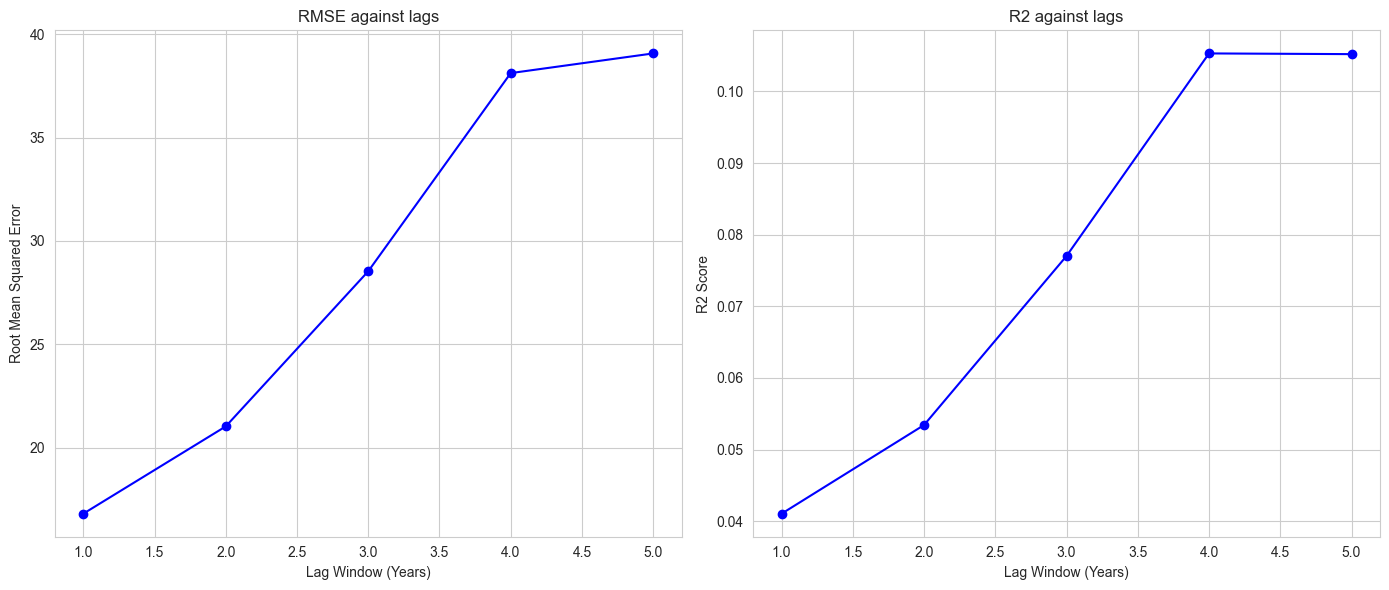

Evaluating for age group: 20 - 24 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


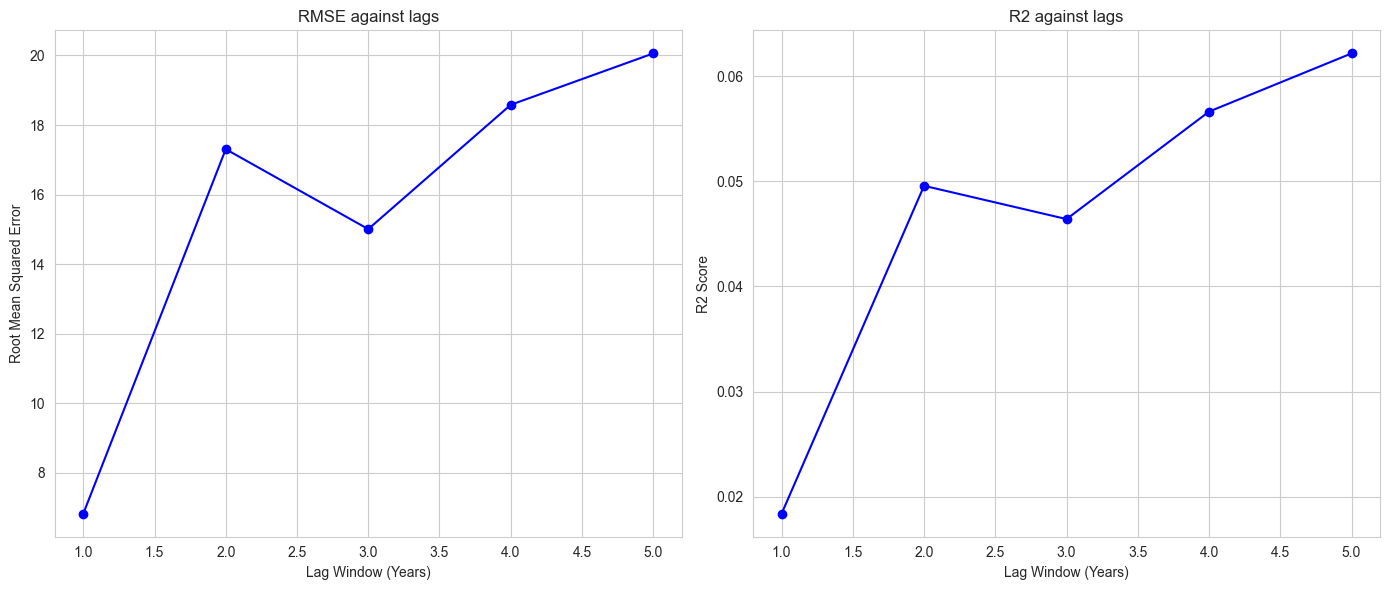

Evaluating for age group: 25 - 29 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


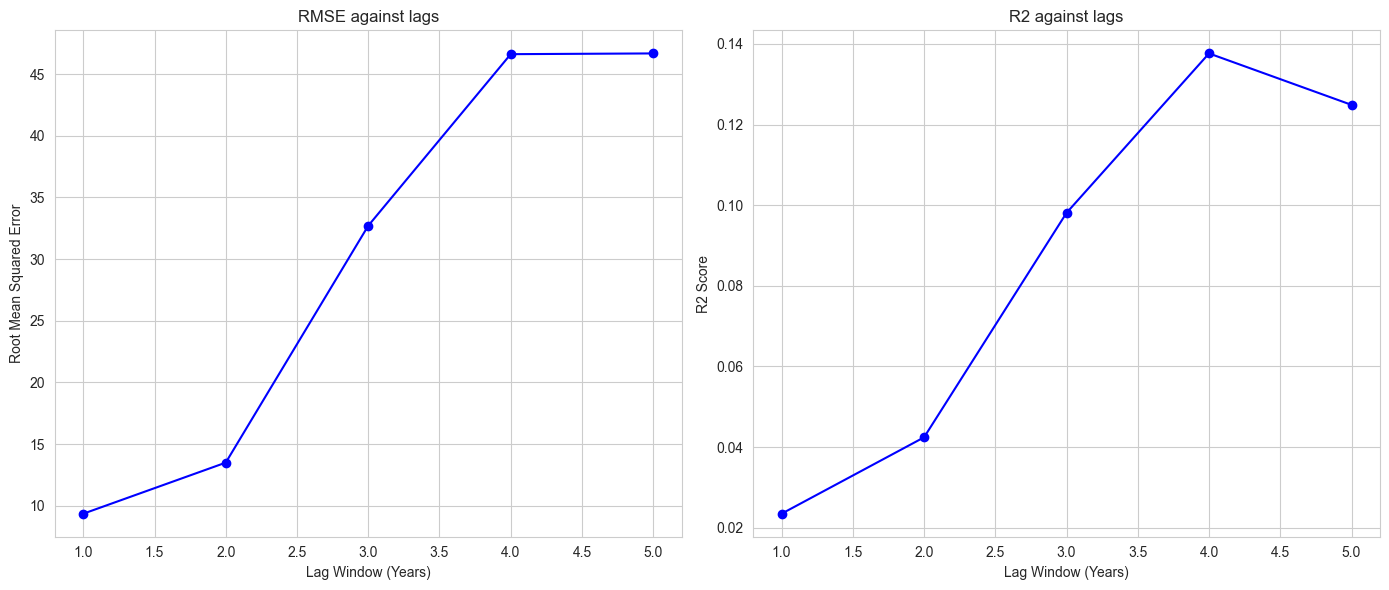

Evaluating for age group: 30 - 34 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


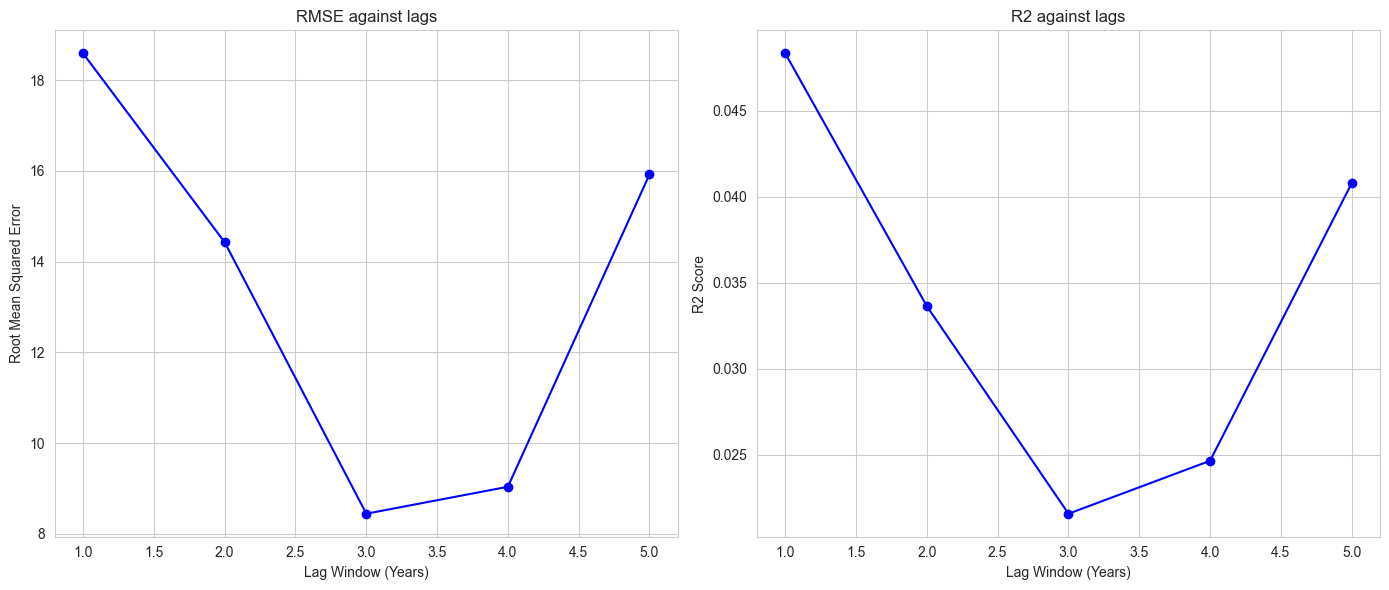

Evaluating for age group: 35 - 39 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


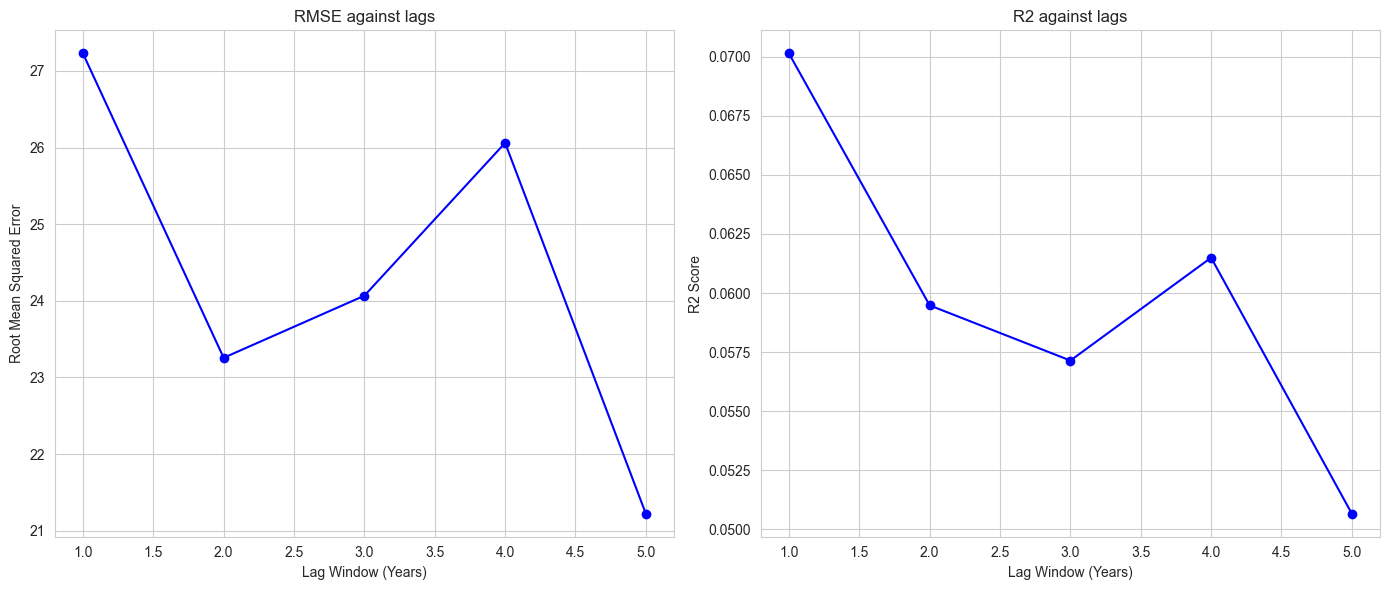

Evaluating for age group: 40 - 44 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


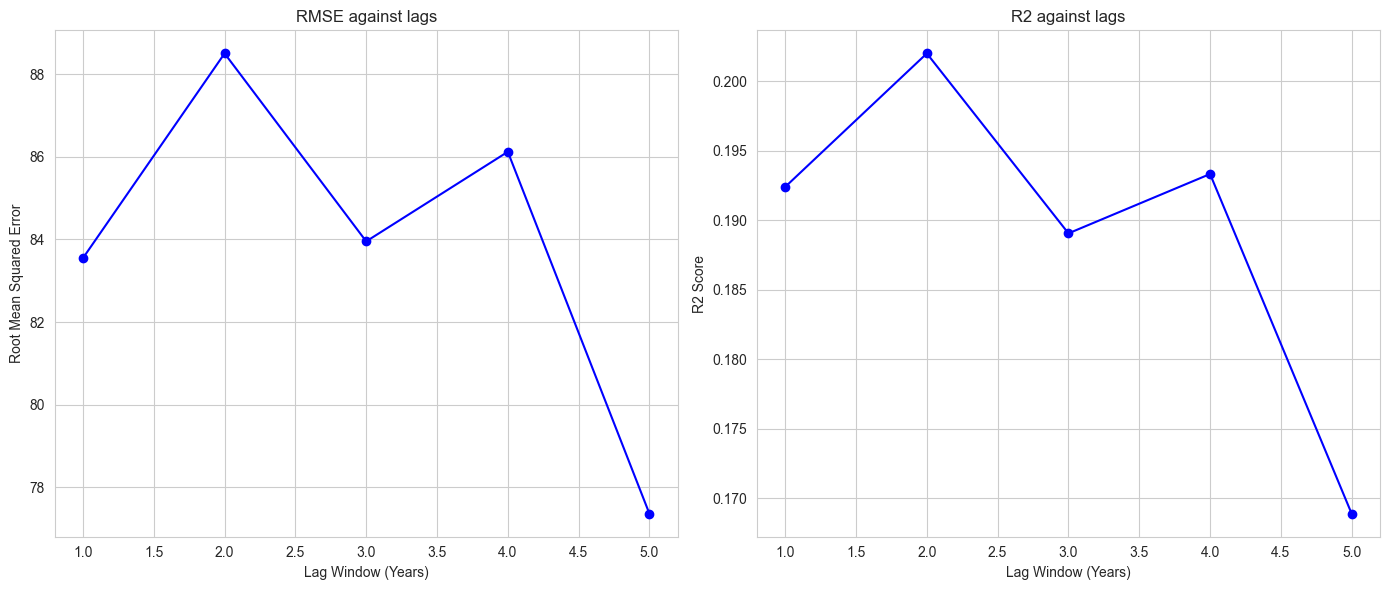

Evaluating for age group: 45 - 49 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


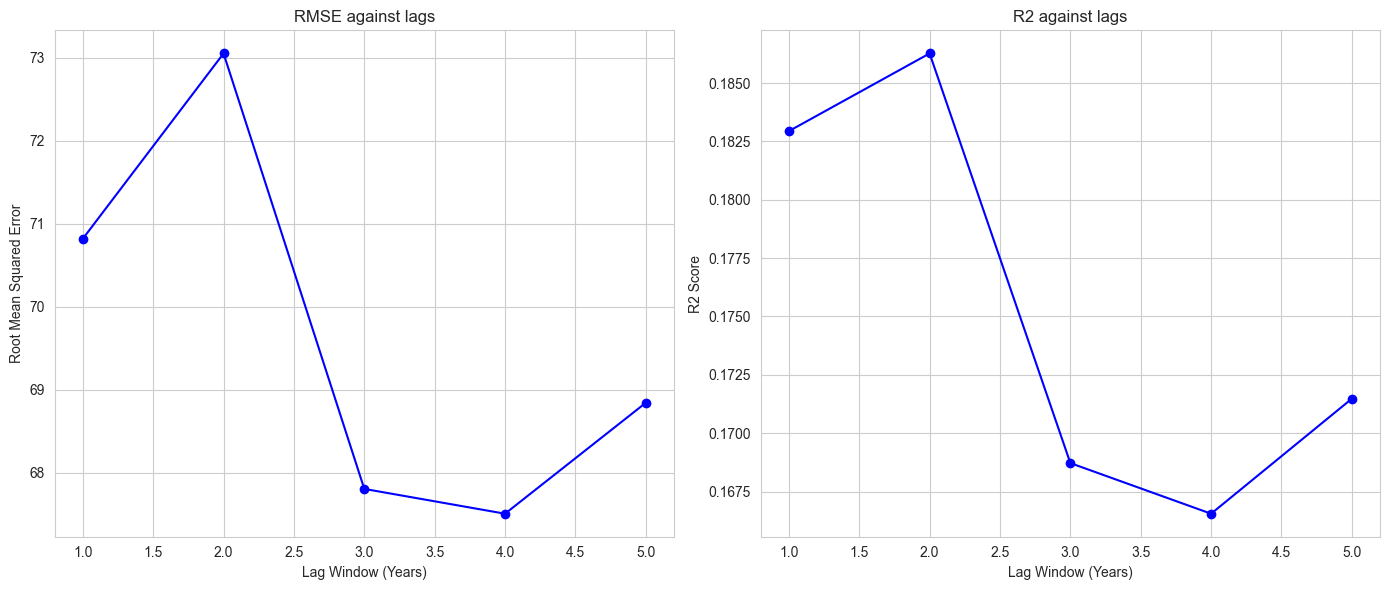

Evaluating for age group: 50 - 54 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


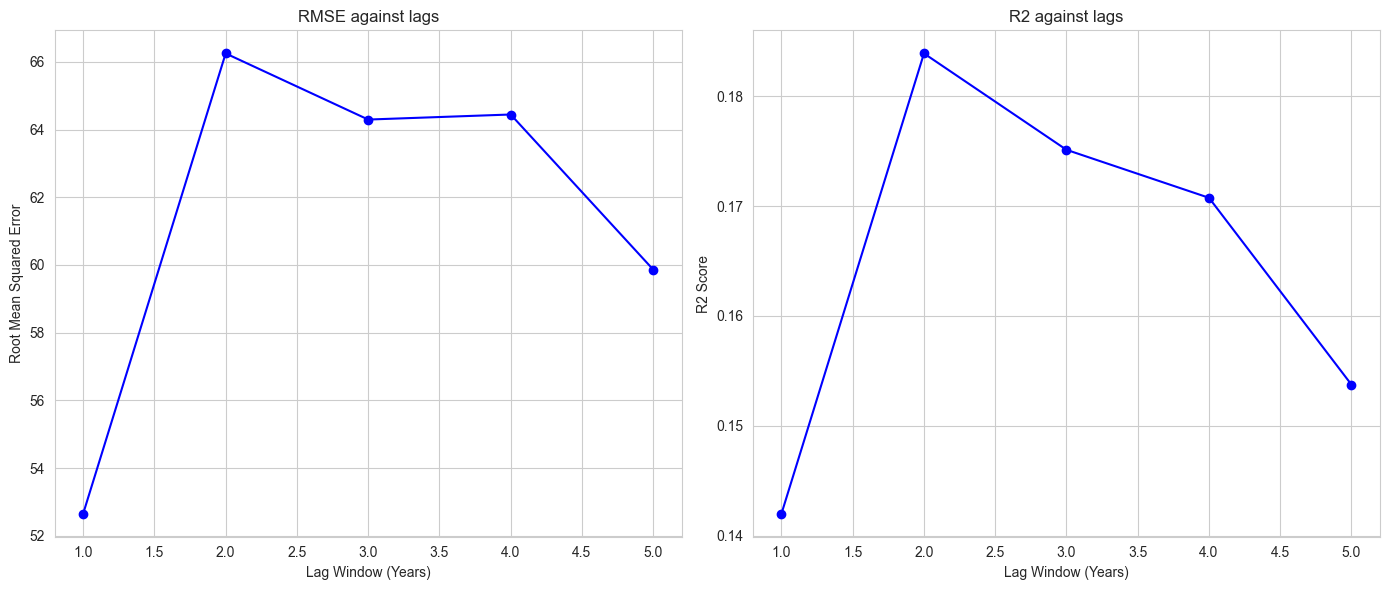

Evaluating for age group: 55 - 59 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


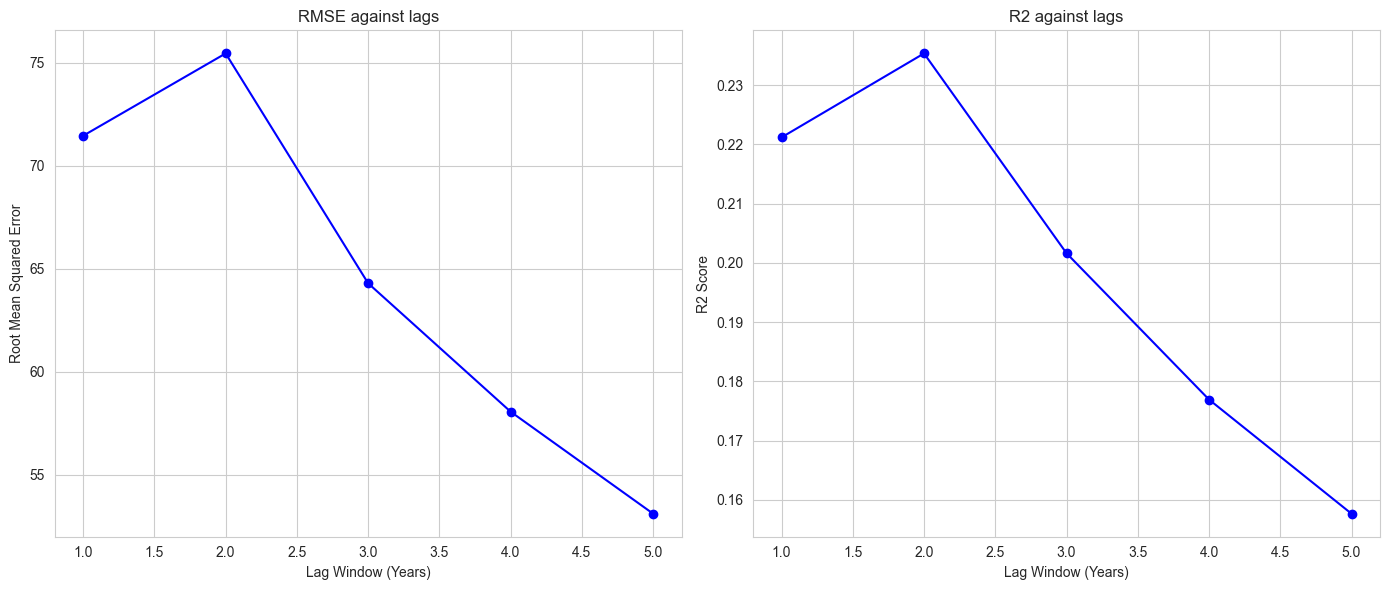

Evaluating for age group: 60 - 64 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


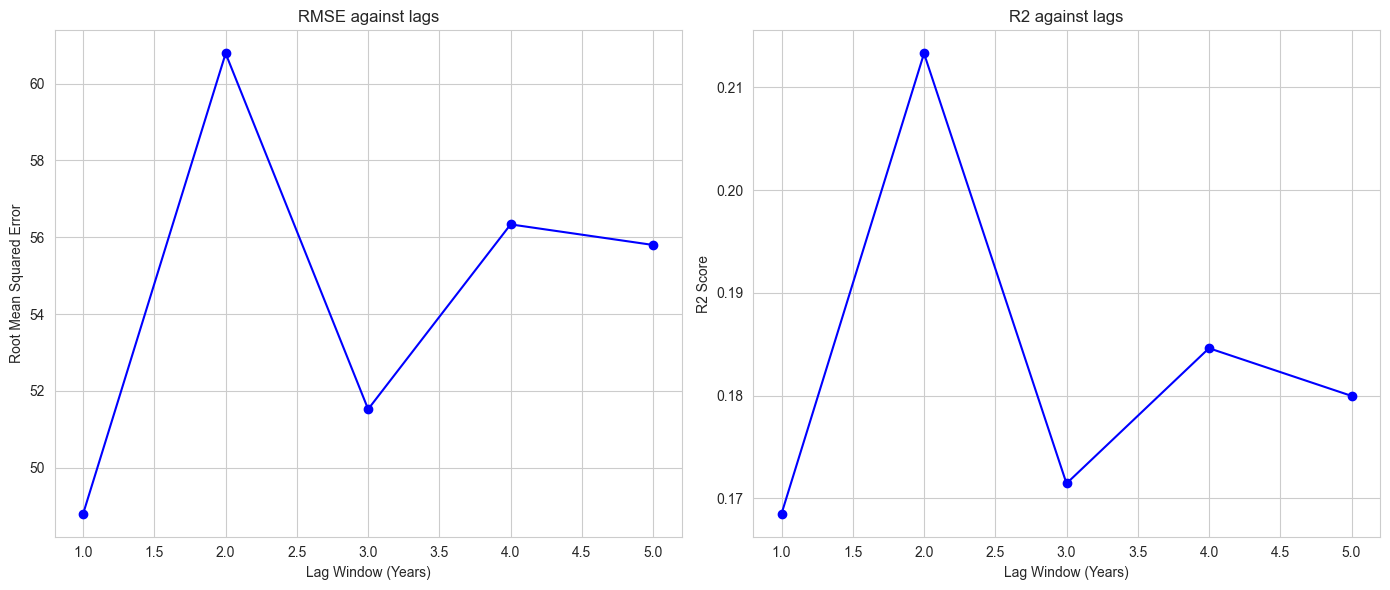

Evaluating for age group: 65 - 69 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


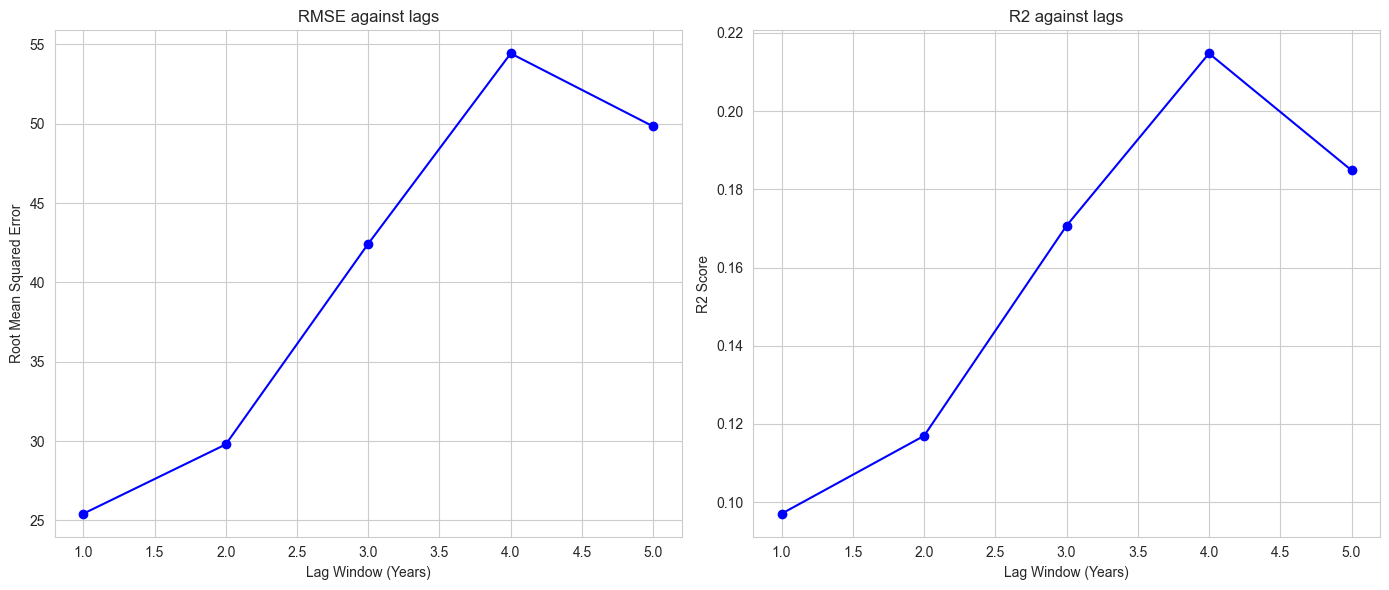

Evaluating for age group: 70 - 74 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


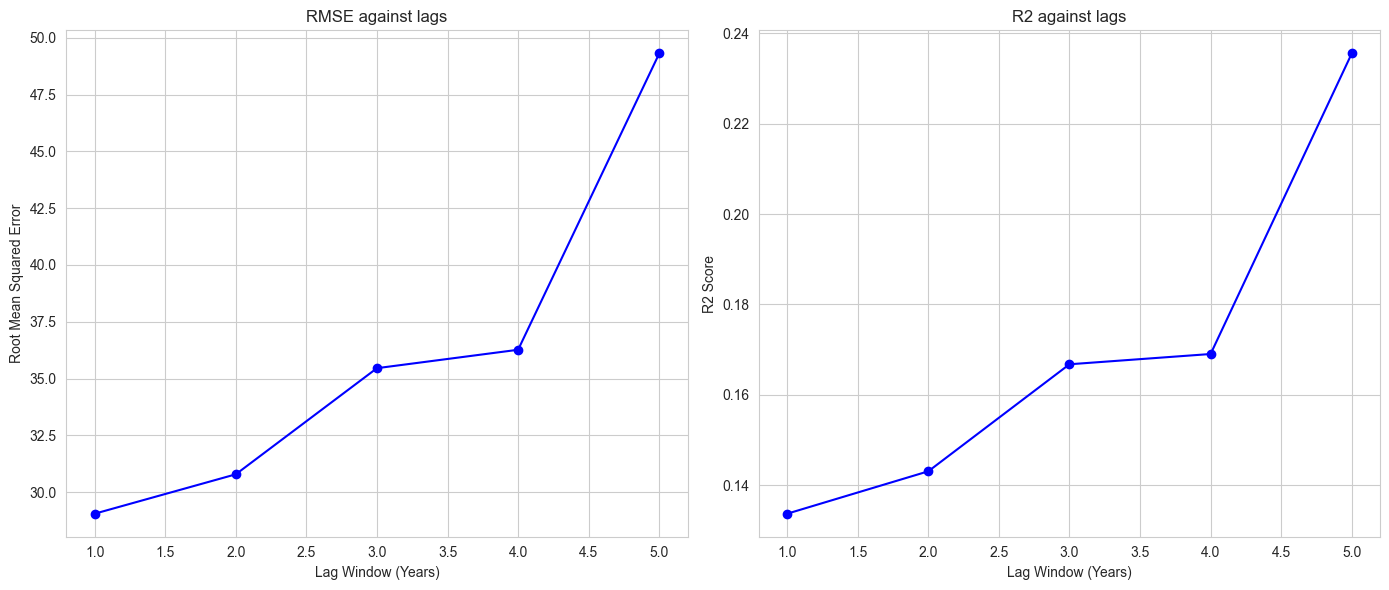

Evaluating for age group: 75 - 79 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


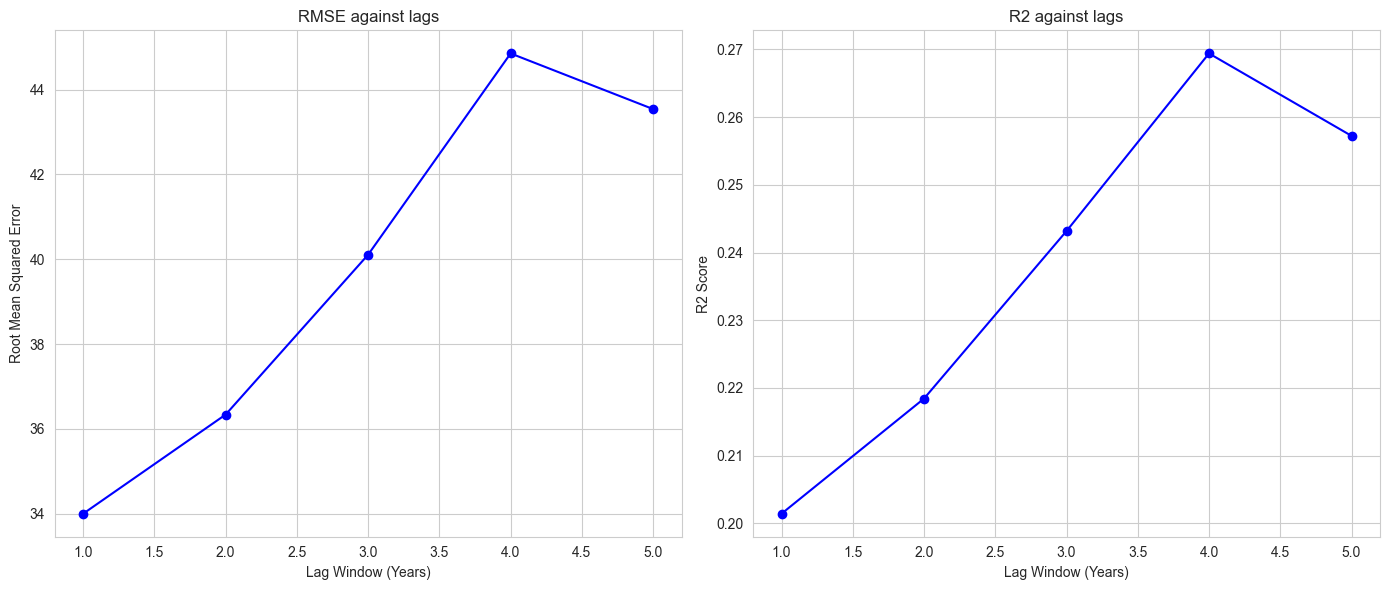

Evaluating for age group: 80 - 84 years
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


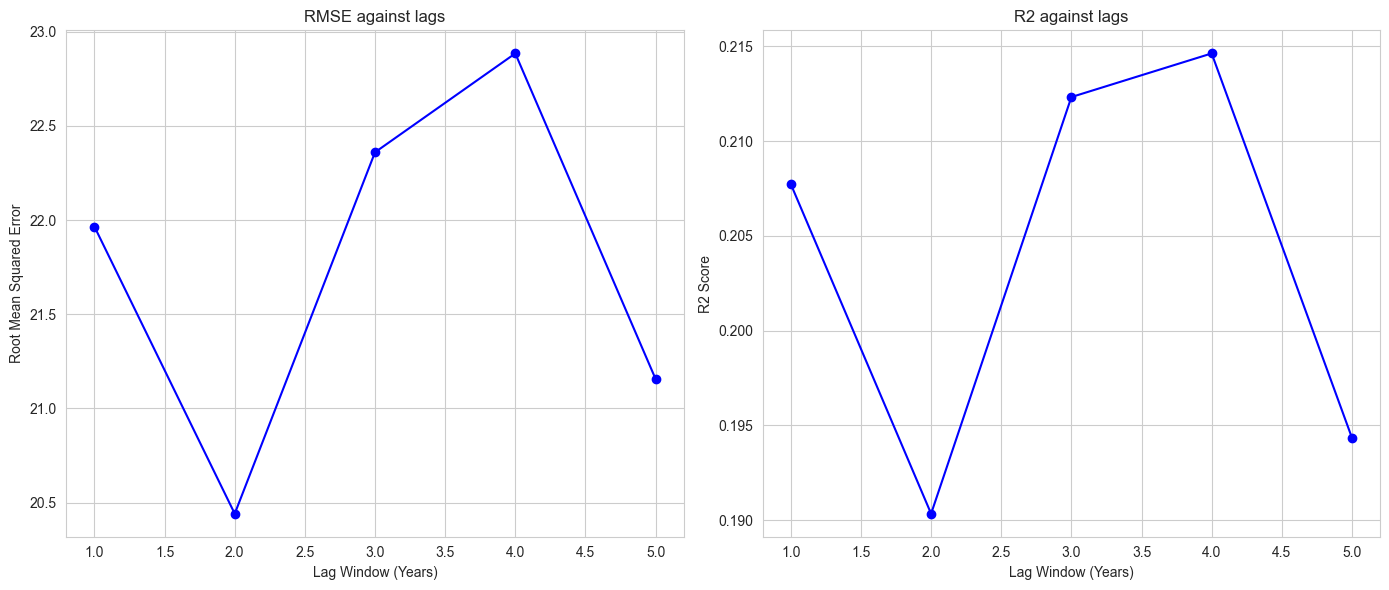

Evaluating for age group: 85 years and over
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


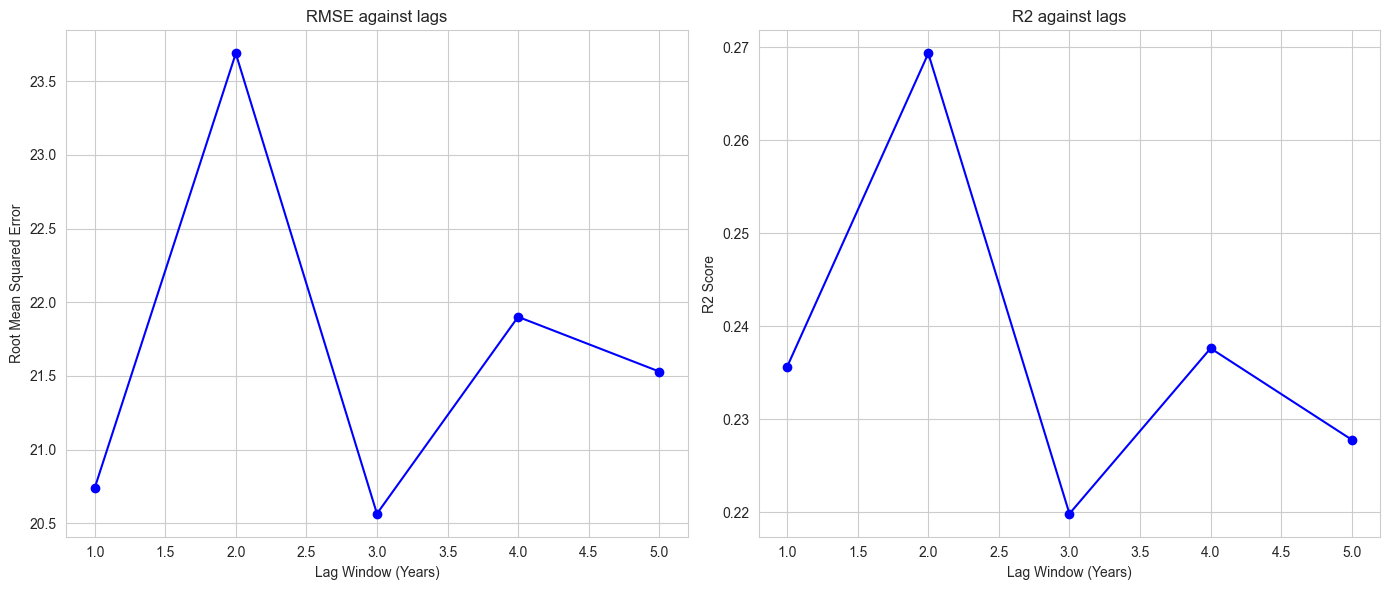

In [14]:
features = ([f'{col} Lag1' for col in age_groups] +
            [f'{col} Lag2' for col in age_groups] +
            [f'{col} Lag3' for col in age_groups] +
            [f'{col} Lag4' for col in age_groups] +
            [f'{col} Lag5' for col in age_groups] +
            ['Migration Lag1', 'Births Lag1', 'Deaths Lag1'] +
            ['Migration Lag2', 'Births Lag2', 'Deaths Lag2'] +
            ['Migration Lag3', 'Births Lag3', 'Deaths Lag3'] +
            ['Migration Lag4', 'Births Lag4', 'Deaths Lag4'] +
            ['Migration Lag5', 'Births Lag5', 'Deaths Lag5'])
models = {}
lags = {}
rmses = []
mapes = []

preds = {}
y_tests = {}
best_preds = {}
testss = {}

for idx, ag in enumerate(age_groups):
    print(f"Evaluating for age group: {ag}")
    max_lag_range = [1, 2, 3, 4, 5]
    
    results, best_models = evaluate_lags(combined_df, ag, max_lag_range)
    best_lag = min(results, key=lambda x: results[x]['rmse'])
    best_model = best_models[best_lag]
    
    models[ag] = best_model
    lags[ag] = best_lag
    
    best_preds[ag] = preds[best_lag]
    testss[ag] = y_tests[best_lag]
    
    rmses.append(results[best_lag]['rmse'])
    mapes.append(results[best_lag]['mape'])
    
    plot_results(results)

Average MAPE: 0.10068681790126087
Average MAPE for elderly populations: 0.1684724265355853
Average RMSE: 27.74
Average RMSE for elderly populations: 25.9


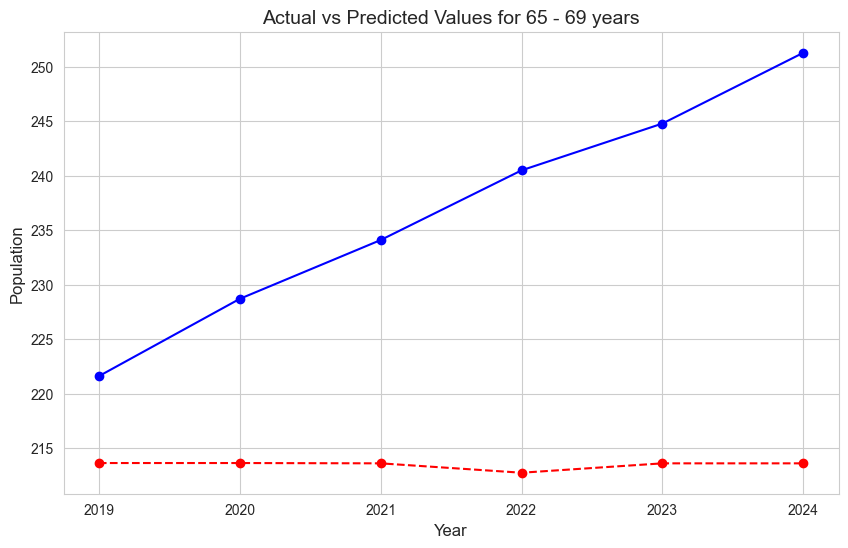

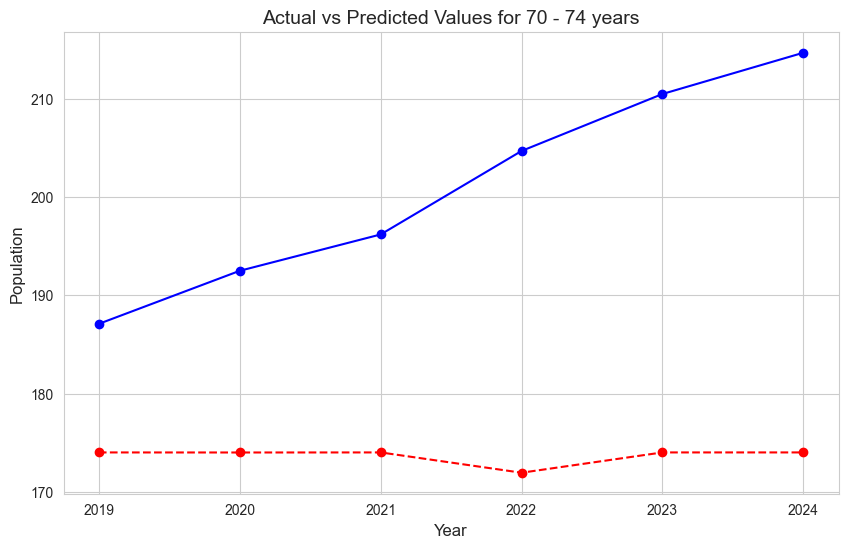

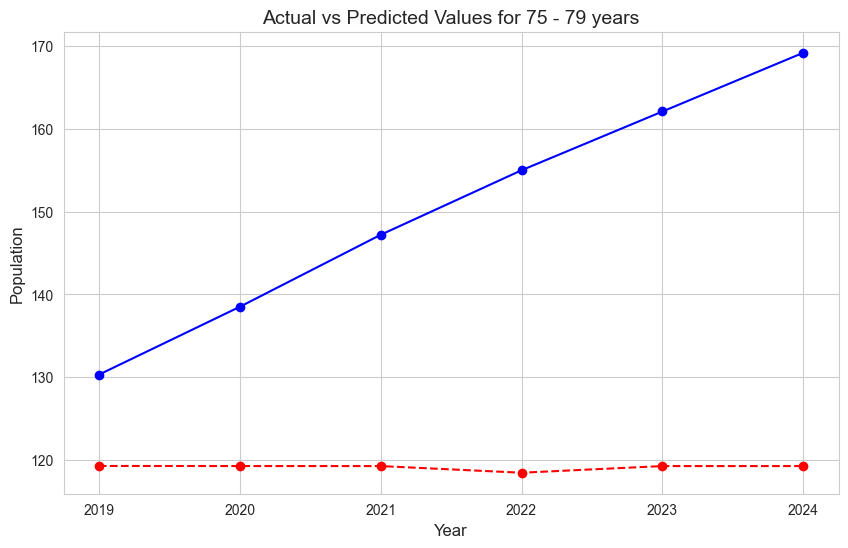

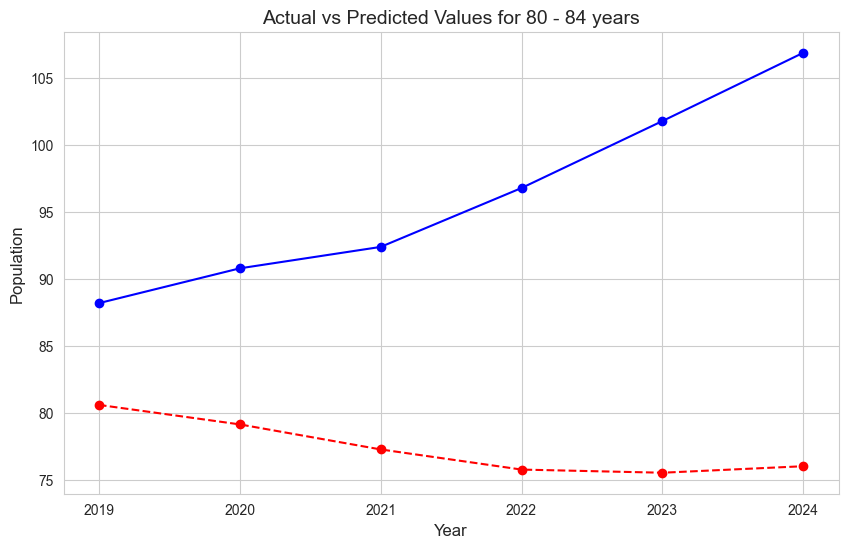

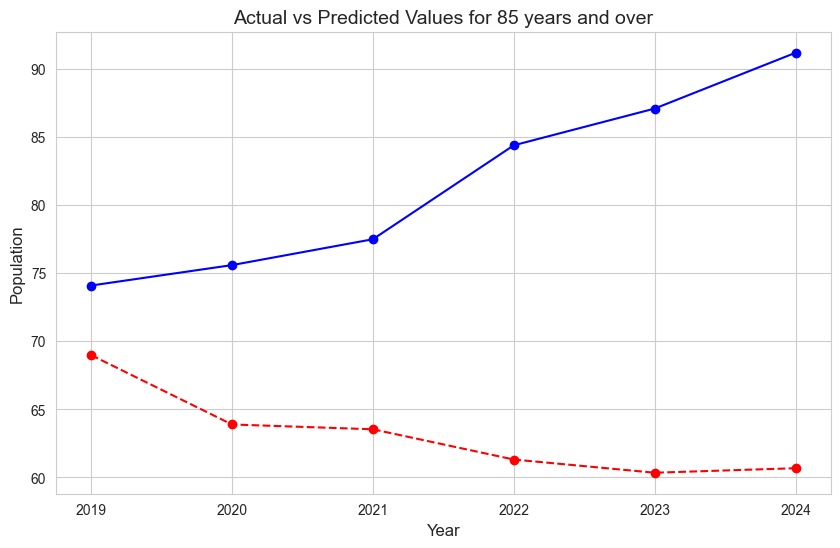

In [15]:
avg_r_score = sum(mapes) / len(mapes)
print('Average MAPE:', avg_r_score)

avg_r_score = sum(mapes[-5:]) / 5
print('Average MAPE for elderly populations:', avg_r_score)

avg_rmse = round(sum(rmses) / len(rmses), 2)
print('Average RMSE:', avg_rmse)

avg_rmse = round(sum(rmses[-5:]) / 5, 2)
print('Average RMSE for elderly populations:', avg_rmse)

for ag in age_groups[-5:]:
    plt.figure(figsize=(10, 6))
    plt.plot(testss[ag], label='Actual Values', color='blue', linestyle='-', marker='o')
    best_preds_series = pd.Series(best_preds[ag], index=testss[ag].index)
    plt.plot(best_preds_series, label='Predicted Values', color='red', linestyle='--', marker='o')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Population', fontsize=12)
    plt.title(f'Actual vs Predicted Values for {ag}', fontsize=14)
    plt.show()

In [16]:
# Forecasting
def forecast_age_group(df, ag, years_forecast, birth_data, death_data, migration_data):
    best_model = models.get(ag)
    best_lag = lags.get(ag)
    df_lagged = create_lagged_df(df.copy(), ag, best_lag)
    
    selected_features = []
    selected_features.extend([f'{ag} Lag{best_lag}'])
    selected_features.extend([f'Migration Lag{best_lag}', f'Births Lag{best_lag}', f'Deaths Lag{best_lag}'])
        
    forecasted_values = []
    last_row = df_lagged.iloc[-1].copy()
    
    for year in range(df_lagged.index[-1] + 1, df_lagged.index[-1] + 1 + years_forecast):
        current_birth = birth_data[year-2022]
        current_death = death_data[year-2022]
        current_migration = migration_data[year-2022]
        last_row['Births Registered (Number)'] = current_birth
        last_row['Deaths Registered (Number)'] = current_death
        last_row['Estimated Migration (Persons in April) (Thousand)'] = current_migration
        
        X_forecast = last_row[selected_features].values.reshape(1, -1)
        forecast_value = best_model.predict(X_forecast)
        forecasted_values.append(forecast_value[0])
        last_row[f'{ag} Lag1'] = forecast_value[0]
        
        for lag in range(2, best_lag + 1):
            last_row[f'{ag} Lag{lag}'] = last_row[f'{ag} Lag{lag - 1}']
        last_row.name = year
    
    forecast_results = pd.DataFrame(forecasted_values, index=np.arange(df_lagged.index[-1] + 1, df_lagged.index[-1] + 1 + years_forecast), columns=[ag])
    return forecast_results

In [17]:
# Making assumptions as are made in official population projections
fertility_rate_2024 = 1.55
fertility_rate_2037 = 1.3
initial_births = 138.09 # in thousands
initial_deaths = 85.56 # in thousands
mortality_improvement_rate = 0.025

years = np.arange(2022, 2042)
births = []
deaths = []

fertility_rate = np.linspace(fertility_rate_2024, fertility_rate_2037, 2037 - 2022 + 1)
for i, year in enumerate(years):
    if year <= 2037:
        births.append(initial_births * (fertility_rate[i] / fertility_rate_2024))
    else:
        births.append(initial_births * (fertility_rate_2037 / fertility_rate_2024))

for i, year in enumerate(years):
    if year == 2022:
        deaths.append(initial_deaths)
    else:
        deaths.append(deaths[-1] * (1 - mortality_improvement_rate))

m1, m2, m3 = [], [], []
m1_val, m2_val, m3_val = 65, 66, 62
for i, year in enumerate(years):
    if year <= 2027:
        m1.append(m1_val)
        m1_val -= 5
    if year > 2027:
        m1.append(45)
    if year <= 2032:
        m2.append(m2_val)
        m2_val -= 4.5
        m3.append(m3_val)
        m3_val -= 6.5
    if year > 2032:
        m2.append(30)
        m3.append(10)

forecast_df_m1 = pd.DataFrame({
    'Year': years,
    'Births Registered (Number)': births,
    'Deaths Registered (Number)': deaths,
    'Estimated Migration (Persons in April) (Thousand)': m1
})

forecast_df_m2 = pd.DataFrame({
    'Year': years,
    'Births Registered (Number)': births,
    'Deaths Registered (Number)': deaths,
    'Estimated Migration (Persons in April) (Thousand)': m1
})

forecast_df_m3 = pd.DataFrame({
    'Year': years,
    'Births Registered (Number)': births,
    'Deaths Registered (Number)': deaths,
    'Estimated Migration (Persons in April) (Thousand)': m1
})

forecast_df_m1 = forecast_df_m1.set_index('Year')
forecast_df_m2 = forecast_df_m2.set_index('Year')
forecast_df_m3 = forecast_df_m3.set_index('Year')

last_three_rows = population_df.tail(3)
last_19_columns = last_three_rows.iloc[:, -19:]

forecast_population_df = pd.DataFrame(np.zeros((len(years), len(last_19_columns.columns))), columns=last_19_columns.columns, index=years)

forecast_population_df.loc[2022] = last_19_columns.iloc[0]
forecast_population_df.loc[2023] = last_19_columns.iloc[1]
forecast_population_df.loc[2024] = last_19_columns.iloc[2]
forecast_population_df.loc[2025] = last_19_columns.iloc[2]
forecast_population_df.loc[2026] = last_19_columns.iloc[2]

forecast_df_m1 = pd.merge(forecast_df_m1, forecast_population_df, left_index=True, right_index=True, how='left').iloc[:5]
forecast_df_m2 = pd.merge(forecast_df_m2, forecast_population_df, left_index=True, right_index=True, how='left').iloc[:5]
forecast_df_m3 = pd.merge(forecast_df_m3, forecast_population_df, left_index=True, right_index=True, how='left').iloc[:5]

# todo: why the hell does 30-34 years not work but the rest do???
forecast_df_m1.drop('30 - 34 years', axis=1, inplace=True)
forecast_df_m2.drop('30 - 34 years', axis=1, inplace=True)
forecast_df_m3.drop('30 - 34 years', axis=1, inplace=True)

C:\Users\bayan\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\bayan\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\bayan\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\bayan\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\bayan\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\bayan\miniconda3\Lib\site-packages\sklearn\base.py:

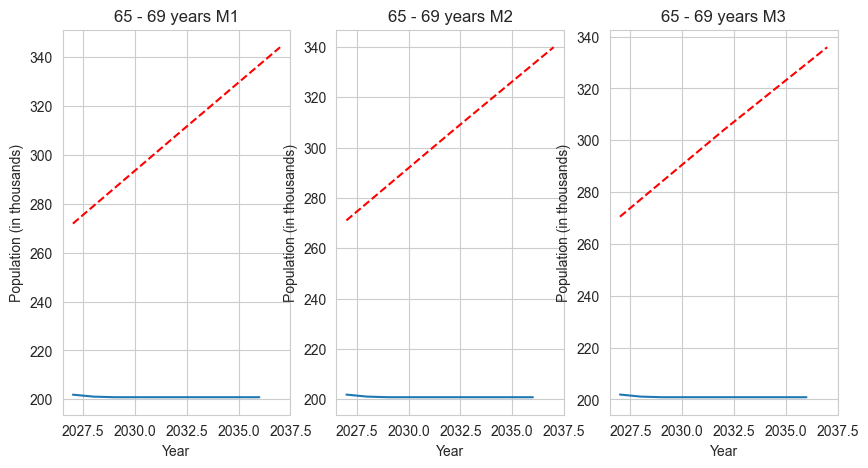

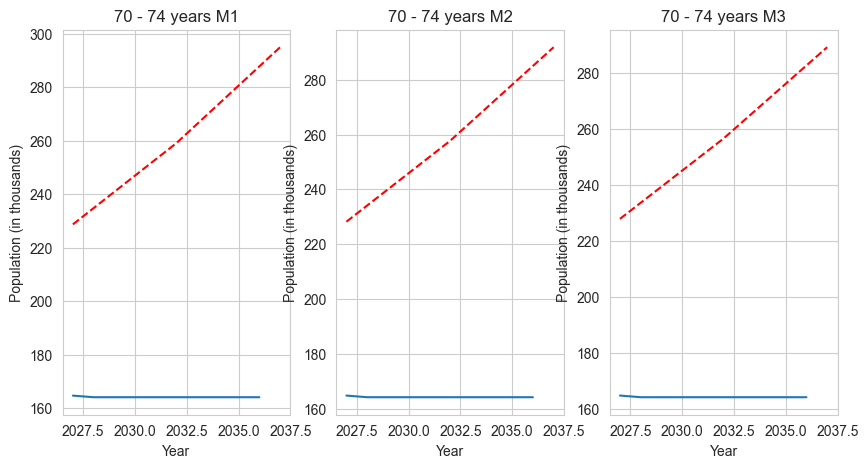

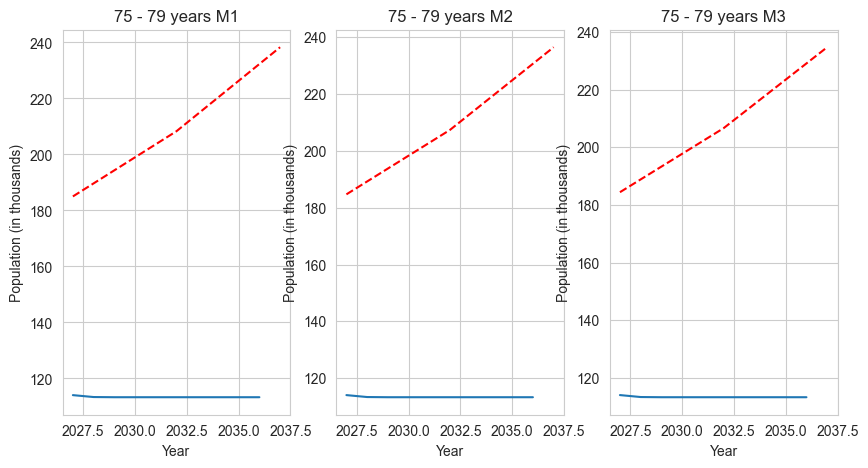

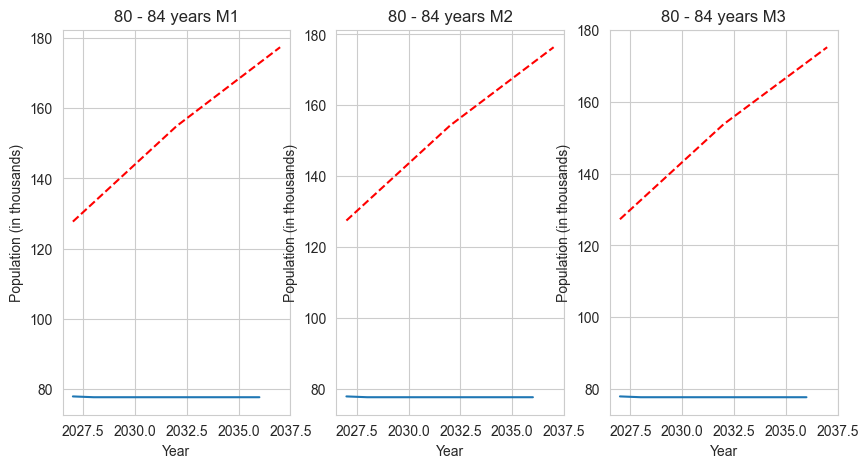

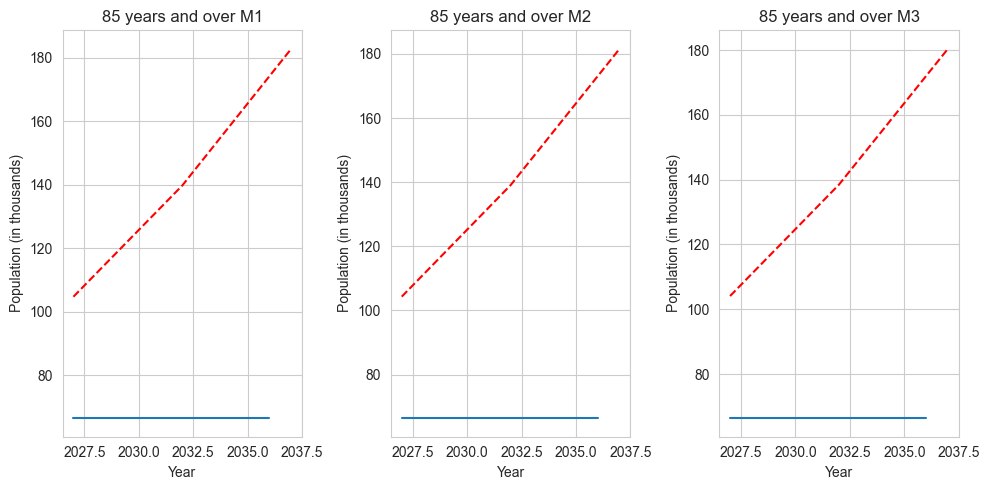

In [19]:
# Read data from CSV and remove unnecessary columns
df_projections = pd.read_csv('../data/PEC23-ProjectedPopByAgeGroup.csv', index_col='Year')
df_projections.drop(columns=['Statistic', 'UNIT'], inplace=True)

# Getting the three different methods of projection
projections_m1 = df_projections[df_projections['Criteria for Projection'] == 'Method - M1']
projections_m2 = df_projections[df_projections['Criteria for Projection'] == 'Method - M2']
projections_m3 = df_projections[df_projections['Criteria for Projection'] == 'Method - M3']

x_ticks = [2022, 2027, 2032, 2037, 2042]

for ag in age_groups[-5:]:
    if ag == '30 - 34 years':
        continue
    forecast_m1 = forecast_age_group(forecast_df_m1, ag, 10, births[5:], deaths[5:], m1[5:])
    forecast_m2 = forecast_age_group(forecast_df_m2, ag, 10, births[5:], deaths[5:], m2[5:])
    forecast_m3 = forecast_age_group(forecast_df_m3, ag, 10, births[5:], deaths[5:], m3[5:])
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    axes[0].plot(forecast_m1.index, forecast_m1.values, label='predicted')
    axes[0].plot(projections_m1[ag][1:-4].index, projections_m1[ag][1:-4], label='projected', color='red', linestyle='dashed')
    axes[0].set_title(f'{ag} M1')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Population (in thousands)')
    
    axes[1].plot(forecast_m2.index, forecast_m2.values, label='predicted')
    axes[1].plot(projections_m2[ag][1:-4].index, projections_m2[ag][1:-4], label='projected', color='red', linestyle='dashed')
    axes[1].set_title(f'{ag} M2')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Population (in thousands)')
    
    axes[2].plot(forecast_m3.index, forecast_m3.values, label='predicted')
    axes[2].plot(projections_m3[ag][1:-4].index, projections_m3[ag][1:-4], label='projected', color='red', linestyle='dashed')
    axes[2].set_title(f'{ag} M3')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Population (in thousands)')
    
plt.tight_layout()
plt.show()